In [55]:
from itertools import cycle
import numpy as np
import pandas as pd
from sklearn.linear_model import lasso_path
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LassoCV
import matplotlib.gridspec as gridspec
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.regressor import ResidualsPlot


In [2]:
seed = 93
random.seed(seed)
np.random.seed(seed)
sqft_train = pd.read_csv("sqft_train.csv")
sqft_test = pd.read_csv("sqft_test.csv")
print(sqft_train.columns)

Index(['air.level', 'base.num', 'baths', 'beds', 'busi.level', 'covered.fee',
       'garage.fee', 'has.covered', 'has.garage', 'has.lot', 'has.street',
       'lot.fee', 'neighborhood', 'pet.allowed', 'pet.deposit', 'pet.fee',
       'pet.rent', 'shopping.num', 'sqft', 'traffic.level', 'zip', 'lat',
       'lng', 'has.parking', 'bed_count', 'bath_count', 'has.pub.elementary',
       'has.priv.elementary', 'has.pub.mid', 'has.cha.high', 'has.priv.high',
       'count.pub.high', 'pub.elt.mid', 'priv.elt.mid', 'has.cha.mid.high',
       'has.priv.mid.high', 'has.pub.mid.high', 'priv.el.hi', 'cha.elt.mid.hi',
       'priv.elt.mid.hi', 'PC1', 'PC2', 'PC3', 'PC4'],
      dtype='object')


In [3]:
sqft_tr_X = sqft_train.loc[:, sqft_train.columns != "sqft"]
sqft_tr_Y = sqft_train.loc[:, "sqft"]
sqft_ts_X = sqft_test.loc[:, sqft_test.columns != "sqft"]
sqft_ts_Y = sqft_test.loc[:, "sqft"]

categories = [
    'air.level', 'base.num', 'busi.level', 'has.covered', 'has.garage',
    'has.lot', 'has.street', 'neighborhood', 'pet.allowed',
    'traffic.level', 'has.parking', 'has.pub.elementary',
    'has.priv.elementary', 'has.pub.mid', 'has.cha.high',
    'has.priv.high', 'count.pub.high', 'pub.elt.mid', "bed_count", "bath_count",
    'priv.elt.mid', 'has.cha.mid.high', 'has.priv.mid.high', 'has.pub.mid.high',
    'priv.el.hi', 'cha.elt.mid.hi', 'priv.elt.mid.hi', "zip"
]

sqft_tr_X = pd.get_dummies(sqft_tr_X, columns=categories)
sqft_ts_X = pd.get_dummies(sqft_ts_X, columns=categories)

In [4]:
lasso_cv = LassoCV(max_iter=50000, cv=10, random_state=seed).fit(sqft_tr_X, sqft_tr_Y)

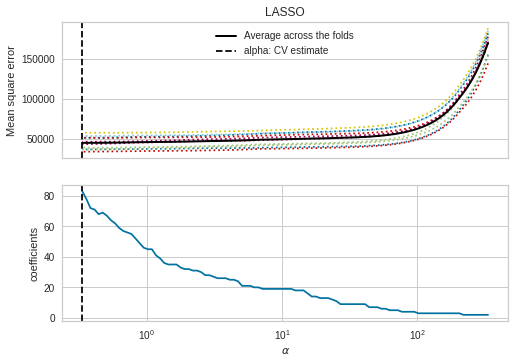

In [5]:
gs = gridspec.GridSpec(2,1)
fig = plt.figure()
ax = fig.add_subplot(gs[0])
ax.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_, linestyle=":")
ax.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
ax.axvline(lasso_cv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
ax.set_ylabel("Mean square error")
ax.legend()
ax.set_title(
    "LASSO"
)
ax.axes.get_xaxis().set_visible(False)

ax = fig.add_subplot(gs[1], sharex=ax)
alphas_lasso, coefs_lasso, _ = lasso_path(sqft_tr_X, sqft_tr_Y,
                                          alphas=lasso_cv.alphas_,
                                          max_iter=50000)
colors = cycle(["b", "r", "g", "c", "k"])
coef_count = []
for i, _ in enumerate(alphas_lasso):
    count = 0
    for coefs in coefs_lasso:
        if coefs[i] != 0:
            count += 1
    coef_count.append(count)

ax.semilogx(alphas_lasso, coef_count)
ax.axvline(lasso_cv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")
ax.set_ylabel("coefficients")
ax.set_xlabel(r"$\alpha$")
plt.show()


In [6]:
coef_idx = lasso_cv.coef_ != 0
coefficients = lasso_cv.coef_[coef_idx]
coefficients = pd.Series(coefficients, sqft_tr_X.columns[coef_idx])
coefficients.abs().sort_values(ascending=False)
selected_tr_X = sqft_tr_X[coefficients.index]

In [7]:
random_forest = RandomForestRegressor(random_state=seed)
params = {
    "n_estimators": range(1, 501, 50)
}
random_tree_cv = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1,
                              cv=10, scoring="neg_mean_squared_error")
random_tree_cv.fit(selected_tr_X, sqft_tr_Y)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=93), n_jobs=-1,
             param_grid={'n_estimators': range(1, 501, 50)},
             scoring='neg_mean_squared_error')

In [8]:
def best_cv(cv):
    cv_result = pd.DataFrame(cv.cv_results_)
    return cv_result, cv_result.loc[cv_result.rank_test_score == 1,
                 ["params", "mean_test_score", "std_test_score"]]


cv_rf_result, best_rf_result = best_cv(random_tree_cv)
best_rf_result

,params,mean_test_score,std_test_score
9,{'n_estimators': 451},-36285.434034,5320.058759


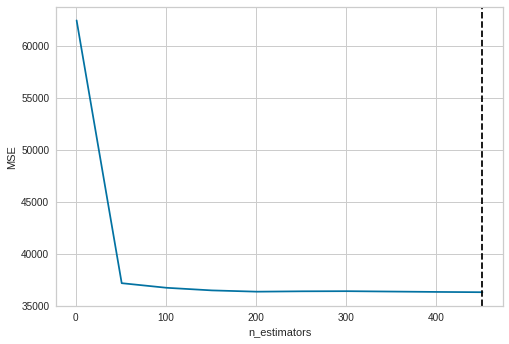

In [9]:
def plot_cv(cv_result, cv, param, x):
    plt.plot(x, -cv_result["mean_test_score"])
    plt.ylabel("MSE")
    plt.xlabel(param)
    plt.axvline(cv.best_params_[param],
            linestyle="--", color="black", label="best")
    plt.show()


plot_cv(cv_rf_result, random_tree_cv, "n_estimators", range(1, 501, 50))

In [10]:
best_rf = random_tree_cv.best_estimator_
rf_perm_imp = permutation_importance(best_rf, selected_tr_X, sqft_tr_Y,
                                     n_repeats=10, n_jobs=-1, random_state=seed)

Text(0.5, 1.0, 'Perm. Feature Importance')

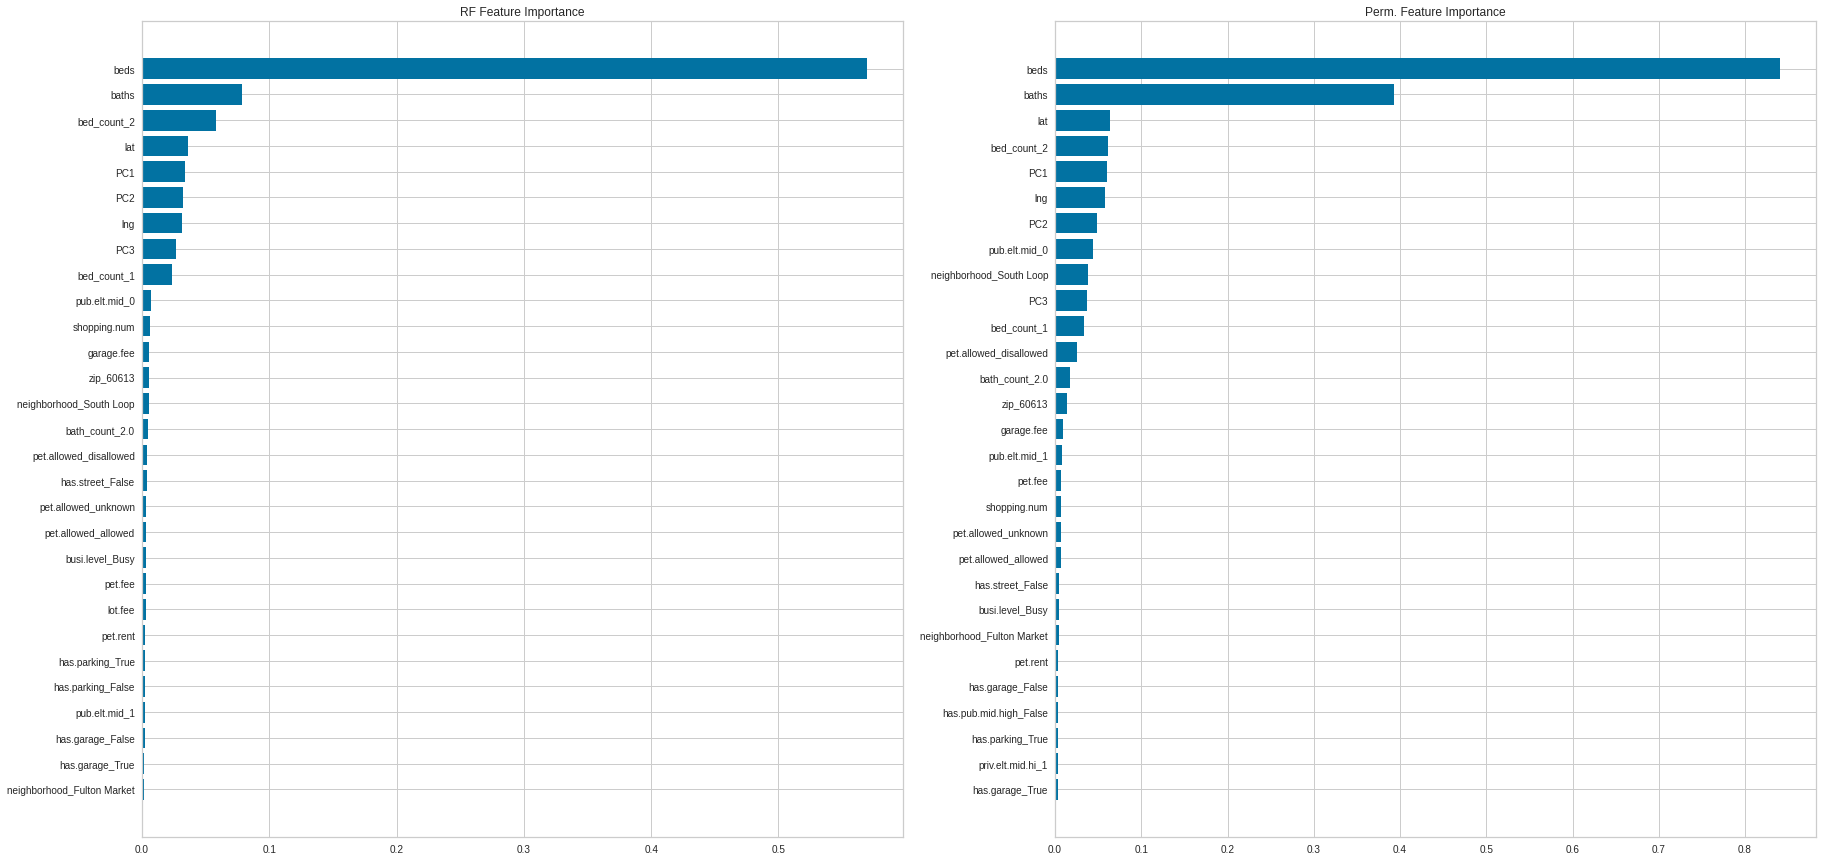

In [11]:
gs = gridspec.GridSpec(1,2)
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(30)
ax = fig.add_subplot(gs[0])
rf_features = pd.Series(best_rf.feature_importances_,
                        selected_tr_X.columns).sort_values(ascending=True)[50:]
feature_pos = np.arange(len(rf_features))
ax.barh(feature_pos, rf_features)
plt.sca(ax)
plt.yticks(feature_pos, rf_features.index)
plt.title("RF Feature Importance")

ax = fig.add_subplot(gs[1])
rf_perm_imp_s = pd.Series(rf_perm_imp.importances_mean,
                        selected_tr_X.columns).sort_values(ascending=True)[50:]
ax.barh(feature_pos, rf_perm_imp_s)
plt.sca(ax)
plt.yticks(feature_pos, rf_perm_imp_s.index)
plt.title("Perm. Feature Importance")

In [47]:
def perf_summary(model, tr_x, ts_x, tr_y, ts_y):
    tr = model.predict(tr_x)
    ts = model.predict(ts_x)

    tr_mse = mean_squared_error(tr_y, tr)
    ts_mse = mean_squared_error(ts_y, ts)
    tr_mae = mean_absolute_error(tr_y, tr)
    ts_mae = mean_absolute_error(ts_y, ts)
    ts_mean = np.mean(ts - ts_y)
    ts_std = np.std(ts - ts_y)

    perf = pd.Series([tr_mse, ts_mse, tr_mae, ts_mae, ts_mean, ts_std],
                    index=["train.mse", "test.mse", "train.mae", "test.mae",
                           "test.mean", "test.stdev"])
    return perf


best_rf = random_tree_cv.best_estimator_
rf_perf = perf_summary(best_rf, sqft_tr_X[coefficients.index], sqft_ts_X[coefficients.index],
                       sqft_tr_Y, sqft_ts_Y)
rf_perf

ValueError: X has 79 features, but DecisionTreeRegressor is expecting 12 features as input.

In [13]:
relevant_features = set(rf_features.index[-9:])
relevant_features = relevant_features.union(set(rf_perm_imp_s.index[-12: ]))
selected_tr_X = selected_tr_X.loc[:, relevant_features]
selected_ts_X = sqft_ts_X.loc[:, relevant_features]

In [14]:
random_tree_cv = GridSearchCV(estimator=random_forest, param_grid=params, n_jobs=-1,
                              cv=10, scoring="neg_mean_squared_error")
random_tree_cv.fit(selected_tr_X, sqft_tr_Y)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=93), n_jobs=-1,
             param_grid={'n_estimators': range(1, 501, 50)},
             scoring='neg_mean_squared_error')

In [15]:
cv_rf_result, best_rf_result = best_cv(random_tree_cv)
best_rf_result

,params,mean_test_score,std_test_score
9,{'n_estimators': 451},-35868.386994,5234.908778


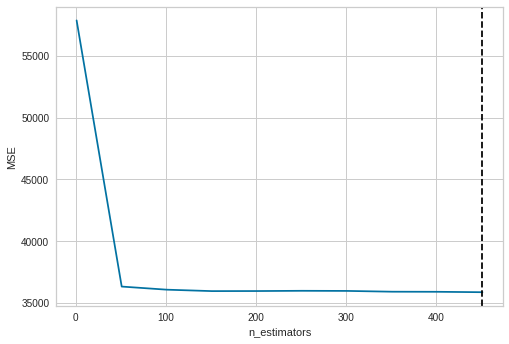

In [16]:
plot_cv(cv_rf_result, random_tree_cv, "n_estimators", range(1, 501, 50))

In [17]:
best_rf = random_tree_cv.best_estimator_
rf_perf = perf_summary(best_rf, selected_tr_X, selected_ts_X,
                       sqft_tr_Y, sqft_ts_Y)
rf_perf

train.mse     9680.970791
test.mse     30134.160469
train.mae       59.033097
test.mae       104.795052
dtype: float64

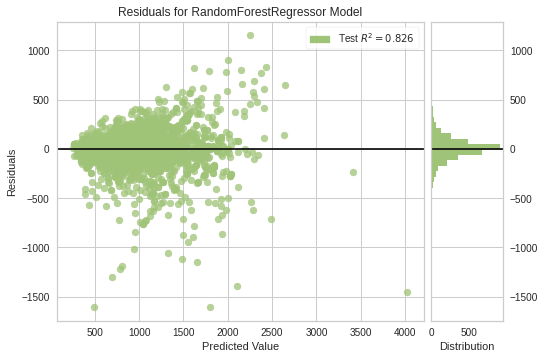

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [18]:
rs_plot = ResidualsPlot(best_rf)
rs_plot.score(selected_ts_X, sqft_ts_Y)
rs_plot.show()

In [19]:
svr = SVR()
svr_param = {
    "gamma": ["scale"] + list(np.arange(0.0001, 0.6, 0.05)),
    "C": np.arange(950, 1050, 10),
    "epsilon": range(75, 125, 5)
}
svr_cv = GridSearchCV(estimator=svr, param_grid=svr_param, n_jobs=-1,
                              cv=10, scoring="neg_mean_squared_error")
svr_cv.fit(selected_tr_X, sqft_tr_Y)

GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([ 950,  960,  970,  980,  990, 1000, 1010, 1020, 1030, 1040]),
                         'epsilon': range(75, 125, 5),
                         'gamma': ['scale', 0.0001, 0.050100000000000006,
                                   0.10010000000000001, 0.1501, 0.2001, 0.2501,
                                   0.30010000000000003, 0.3501, 0.4001, 0.4501,
                                   0.5001, 0.5501]},
             scoring='neg_mean_squared_error')

In [20]:
cv_svr_result, best_svr_result = best_cv(svr_cv)
best_svr_result

,params,mean_test_score,std_test_score
699,"{'C': 1000, 'epsilon': 90, 'gamma': 0.4501}",-43184.246233,7803.839871


In [21]:
best_svr = svr_cv.best_estimator_
svr_perf = perf_summary(best_svr, selected_tr_X, selected_ts_X,
                       sqft_tr_Y, sqft_ts_Y)
svr_perf

train.mse    27806.681374
test.mse     40313.753861
train.mae      103.852427
test.mae       125.375988
dtype: float64

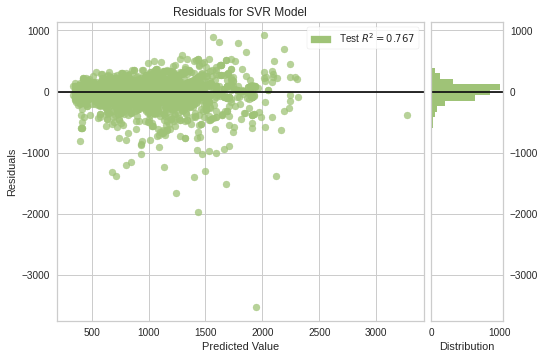

<AxesSubplot:title={'center':'Residuals for SVR Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [22]:
rs_plot = ResidualsPlot(best_svr)
rs_plot.score(selected_ts_X, sqft_ts_Y)
rs_plot.show()

In [23]:
adaboost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=25, random_state=seed), random_state=seed,
                             loss="square")
adaboost_param = {
    "n_estimators": range(1, 101, 5)
}
adaboost_cv = GridSearchCV(adaboost, adaboost_param, n_jobs=-1,
                          cv=10, scoring="neg_mean_squared_error")
adaboost_cv.fit(selected_tr_X, sqft_tr_Y)

GridSearchCV(cv=10,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=25,
                                                                              random_state=93),
                                         loss='square', random_state=93),
             n_jobs=-1, param_grid={'n_estimators': range(1, 101, 5)},
             scoring='neg_mean_squared_error')

In [24]:
adaboost_cv_result, best_ada_res = best_cv(adaboost_cv)
best_ada_res

,params,mean_test_score,std_test_score
8,{'n_estimators': 41},-36785.223247,5983.282034


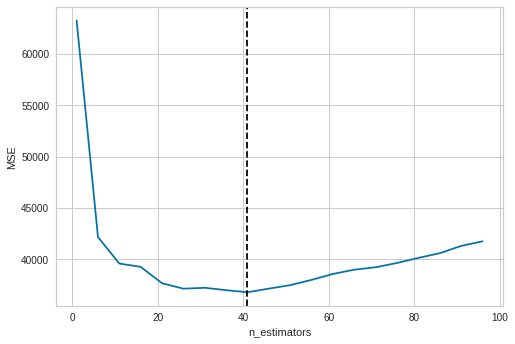

In [25]:
plot_cv(adaboost_cv_result, adaboost_cv, "n_estimators", range(1, 101, 5))

In [26]:
best_ada = adaboost_cv.best_estimator_
ada_perf = perf_summary(best_ada, selected_tr_X, selected_ts_X,
                       sqft_tr_Y, sqft_ts_Y)
ada_perf

train.mse    13946.017291
test.mse     32920.980906
train.mae       67.402745
test.mae       108.634676
dtype: float64

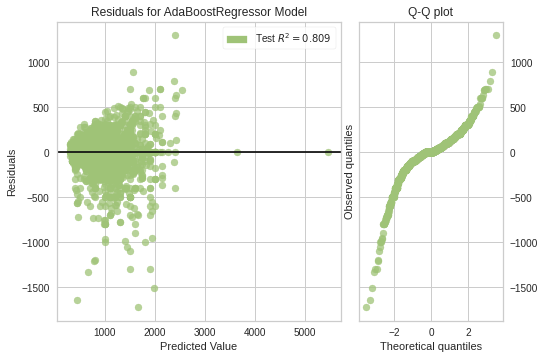

<AxesSubplot:title={'center':'Residuals for AdaBoostRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [54]:
rs_plot = ResidualsPlot(best_ada)
rs_plot.score(selected_ts_X, sqft_ts_Y)
rs_plot.show()

In [28]:
bag_ada_params = {
    "n_estimators": range(1, 101, 10)
}
bag_ada_base = AdaBoostRegressor(DecisionTreeRegressor(max_depth=25, random_state=seed), random_state=seed,
                             loss="square", n_estimators=36)
bag_ada = BaggingRegressor(bag_ada_base, random_state=seed)
bag_ada_cv = GridSearchCV(estimator=bag_ada, param_grid=bag_ada_params, n_jobs=-1,
                          cv=10, scoring="neg_mean_squared_error")
bag_ada_cv.fit(selected_tr_X, sqft_tr_Y)

GridSearchCV(cv=10,
             estimator=BaggingRegressor(base_estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=25,
                                                                                                              random_state=93),
                                                                         loss='square',
                                                                         n_estimators=36,
                                                                         random_state=93),
                                        random_state=93),
             n_jobs=-1, param_grid={'n_estimators': range(1, 101, 10)},
             scoring='neg_mean_squared_error')

In [29]:
bag_ada_cv_cv_result, best_bag_ada = best_cv(bag_ada_cv)
best_bag_ada

,params,mean_test_score,std_test_score
3,{'n_estimators': 31},-34321.629509,5432.550841


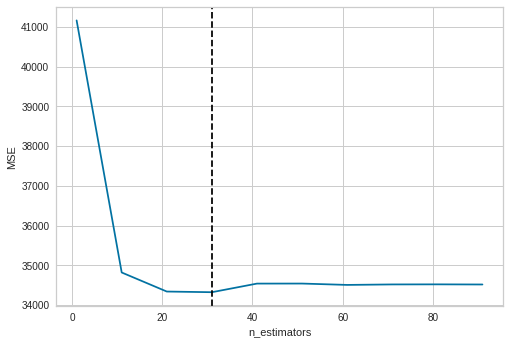

In [30]:
plot_cv(bag_ada_cv_cv_result, bag_ada_cv, "n_estimators", range(1, 101, 10))

In [31]:
best_ada_bag = bag_ada_cv.best_estimator_
ada_perf = perf_summary(best_ada_bag, selected_tr_X, selected_ts_X,
                       sqft_tr_Y, sqft_ts_Y)
ada_perf

train.mse    13845.439821
test.mse     31405.158715
train.mae       73.994235
test.mae       107.583623
dtype: float64

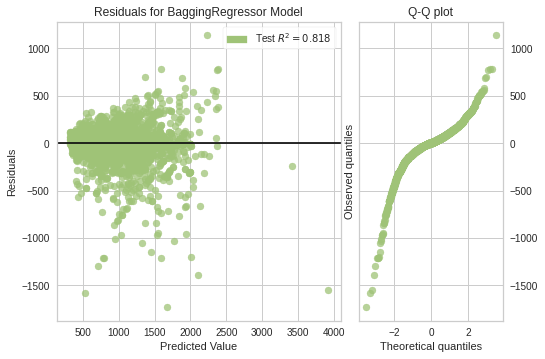

<AxesSubplot:title={'center':'Residuals for BaggingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [53]:
rs_plot = ResidualsPlot(best_ada_bag)
rs_plot.score(selected_ts_X, sqft_ts_Y)
rs_plot.show()


In [57]:
estimators = {
    "rf": best_rf,
    "svr": best_svr,
    "ada": best_ada,
    "bag_ada": best_ada_bag
}
stacking_ridge = StackingRegressor(estimators=list(estimators.items()), cv=10,
                                   n_jobs=-1, passthrough=False)
stacking_ridge.fit(selected_tr_X, sqft_tr_Y)

StackingRegressor(cv=10,
                  estimators=[('rf',
                               RandomForestRegressor(n_estimators=451,
                                                     random_state=93)),
                              ('svr', SVR(C=1000, epsilon=90, gamma=0.4501)),
                              ('ada',
                               AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=25,
                                                                                      random_state=93),
                                                 loss='square', n_estimators=41,
                                                 random_state=93)),
                              ('bag_ada',
                               BaggingRegressor(base_estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=25,
                                                                                                                      random_state=93),
                

In [58]:
stacking_cv = cross_val_score(stacking_ridge, selected_tr_X, sqft_tr_Y,
                              cv=10, scoring="neg_mean_squared_error")
pd.Series([stacking_cv.mean(), stacking_cv.std()], ["cv_mean", "cv_std"])

cv_mean    0.798263
cv_std     0.025600
dtype: float64

In [51]:
stacking_perf = perf_summary(stacking_ridge, selected_tr_X, selected_ts_X,
                       sqft_tr_Y, sqft_ts_Y)
stacking_perf

train.mse     12369.481000
test.mse      30600.285749
train.mae        70.219336
test.mae        106.593308
test.mean        -3.544799
test.stdev      174.893454
dtype: float64

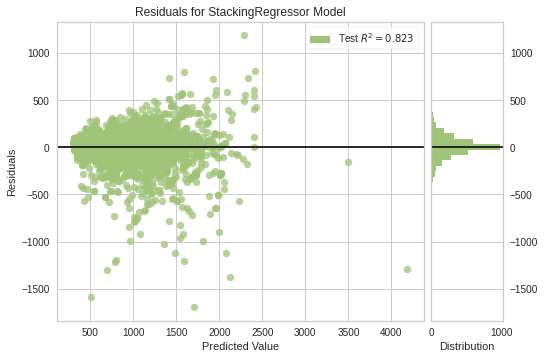

<AxesSubplot:title={'center':'Residuals for StackingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [52]:
rs_plot = ResidualsPlot(stacking_ridge)
rs_plot.score(selected_ts_X, sqft_ts_Y)
rs_plot.show()